In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
PATH_TO_MODEL = "anal-model-jit-script.pth"
PATH_TO_DATASET = "MNIST_test_data"
MEAN, STD = [0.1307], [0.3081]
BATCH_SIZE = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from typing import Any, Callable, cast, Dict, List, Optional, Tuple
class AnalDataset(datasets.ImageFolder):
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        path = path.replace("\\", "/")
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return path, (sample, target)    

In [4]:
dataset = AnalDataset(root=PATH_TO_DATASET, 
                      transform=transforms.Compose([
                          transforms.Grayscale(num_output_channels=1), 
                          transforms.ToTensor(), 
                          transforms.Normalize(mean=MEAN, std=STD)]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Length {len(dataset)}")

Length 1000


path='MNIST_test_data/0/101.jpg'; target=0; shape=torch.Size([1, 28, 28])


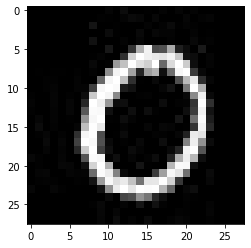

In [6]:
import matplotlib.pyplot as plt
path, (tensor_image, target) = dataset[1]
plt.imshow(  tensor_image.permute(1, 2, 0), cmap="gray")
print(f"{path=}; {target=}; shape={tensor_image.shape}" )

In [7]:
model = torch.jit.load(PATH_TO_MODEL, map_location=DEVICE)
model.eval()
pass

In [8]:
from tqdm import tqdm
wrongs = []
images = {}
with torch.no_grad():
    for paths, (tensor_images, targets) in tqdm(dataloader, desc="Checking images", unit="batchs",leave=True):
        tensor_images, targets = tensor_images.cuda(), targets.cuda()
        logits = model(tensor_images)
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        predictions = torch.max(probabilities, dim=1)[1]
        mask = predictions.eq(targets)
        wrong_indexes = torch.where(mask == False)[0]
        # right_indexes = torch.where(mask == True)[0]
        for wrong_index in wrong_indexes:
            wrong_path = paths[wrong_index]
            wrong_pred = predictions[wrong_index].item()
            target = targets[wrong_index].item()
            wrongs.append((wrong_path, wrong_pred, target))
            images.update({wrong_path: tensor_images[wrong_index]})

Checking images:   0%|                                                                      | 0/10 [00:00<?, ?batchs/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\module.py:1051: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return forward_call(*input, **kwargs)
Checking images: 100%|█████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.23batchs/s]


In [9]:
for wrong in wrongs:
    path, pred, target = wrong
    print(f"{path}: predict={pred}; target={target}")

MNIST_test_data/2/1654.jpg: predict=7; target=2
MNIST_test_data/2/9811.jpg: predict=0; target=2
MNIST_test_data/7/3136.jpg: predict=4; target=7
MNIST_test_data/7/846.jpg: predict=0; target=7
MNIST_test_data/8/582.jpg: predict=2; target=8


----------------------
Далее тупа идём по этим путям, залазим в метаданные и по частям собирает флаг....
1. 582: (1/5):YetiCTF{
2. 3136: (2/5):i_hate_t
3. 9811: (3/5):hese_dat
4. 1654: (4/5):aset_ano
5. 846: (5/5):malies}
---------------------
#### FLAG: YetiCTF{i_hate_these_dataset_anomalies}
---------------------